In [1]:
import os

os.makedirs('/content/train', exist_ok=True)
os.makedirs('/content/test', exist_ok=True)

In [14]:
!kaggle datasets download -d slenser/data-audio-mnist
!unzip data-audio-mnist.zip -d /content/train

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/train/7_39_5.wav  
  inflating: /content/train/7_39_6.wav  
  inflating: /content/train/7_39_7.wav  
  inflating: /content/train/7_39_8.wav  
  inflating: /content/train/7_39_9.wav  
  inflating: /content/train/7_40_13.wav  
  inflating: /content/train/7_40_14.wav  
  inflating: /content/train/7_40_15.wav  
  inflating: /content/train/7_40_16.wav  
  inflating: /content/train/7_40_17.wav  
  inflating: /content/train/7_40_18.wav  
  inflating: /content/train/7_40_19.wav  
  inflating: /content/train/7_40_2.wav  
  inflating: /content/train/7_40_20.wav  
  inflating: /content/train/7_40_21.wav  
  inflating: /content/train/7_40_22.wav  
  inflating: /content/train/7_40_23.wav  
  inflating: /content/train/7_40_24.wav  
  inflating: /content/train/7_40_25.wav  
  inflating: /content/train/7_40_26.wav  
  inflating: /content/train/7_40_27.wav  
  inflating: /content/train/7_40_28.wav  
  inflating: /

In [15]:
!kaggle datasets download -d slenser/audio-mnist-test
!unzip audio-mnist-test.zip -d /content/test

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/test/3_51_0.wav  
  inflating: /content/test/3_51_1.wav  
  inflating: /content/test/3_51_10.wav  
  inflating: /content/test/3_51_11.wav  
  inflating: /content/test/3_51_12.wav  
  inflating: /content/test/3_51_13.wav  
  inflating: /content/test/3_51_14.wav  
  inflating: /content/test/3_51_15.wav  
  inflating: /content/test/3_51_16.wav  
  inflating: /content/test/3_51_17.wav  
  inflating: /content/test/3_51_18.wav  
  inflating: /content/test/3_51_19.wav  
  inflating: /content/test/3_51_2.wav  
  inflating: /content/test/3_51_20.wav  
  inflating: /content/test/3_51_21.wav  
  inflating: /content/test/3_51_22.wav  
  inflating: /content/test/3_51_23.wav  
  inflating: /content/test/3_51_24.wav  
  inflating: /content/test/3_51_25.wav  
  inflating: /content/test/3_51_26.wav  
  inflating: /content/test/3_51_27.wav  
  inflating: /content/test/3_51_28.wav  
  inflating: /content/test/3_51_2

In [16]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchaudio.transforms import MelSpectrogram, Spectrogram, AmplitudeToDB

In [17]:
# Путь к директории с данными
train_data_path = '/content/train'
test_data_path = '/content/test'

In [18]:
# Функция для чтения аудио файлов и меток
def load_audio_data(data_path):
    audio_files = []
    file_names = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                file_name = str(file)
                file_names.append(file_name)
                file_path = os.path.join(root, file)
                label = int(file_path.split('/')[-1].split('_')[0])
                audio_files.append(file_path)
                labels.append(label)
    return audio_files, file_names, labels

In [19]:
# Загрузка данных
train_audio_files, train_file_names, train_labels = load_audio_data(train_data_path)
test_audio_files, test_file_names, test_labels = load_audio_data(test_data_path)

print(f'Количество обучающих примеров: {len(train_audio_files)}')
print(f'Количество тестовых примеров: {len(test_audio_files)}')

Количество обучающих примеров: 22500
Количество тестовых примеров: 7500


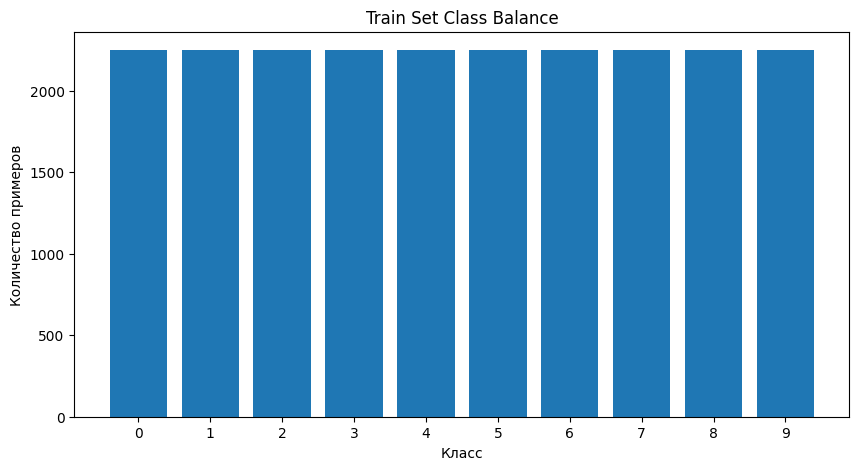

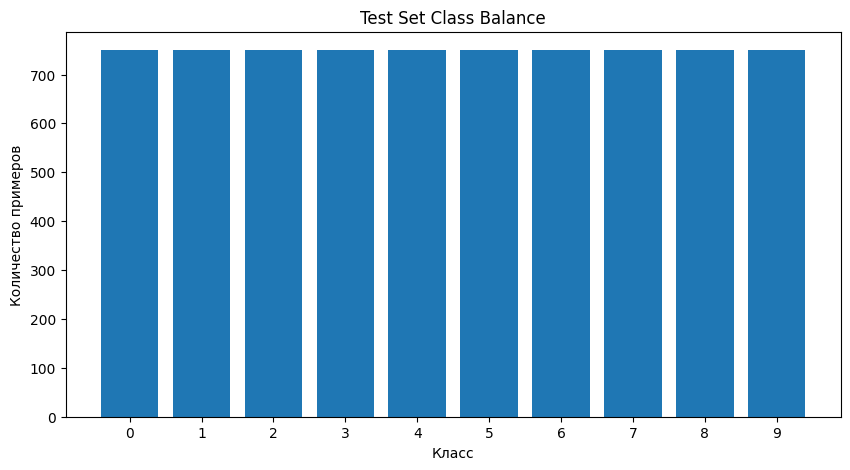

In [ ]:
# баланс классов
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_balance(labels, title="Class Balance"):
    class_counts = Counter(labels)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='tab:blue')
    plt.xlabel('Класс')
    plt.ylabel('Количество примеров')
    plt.title(title)
    plt.xticks(classes)
    plt.show()

plot_class_balance(train_labels, title="Train Set Class Balance")
plot_class_balance(test_labels, title="Test Set Class Balance")

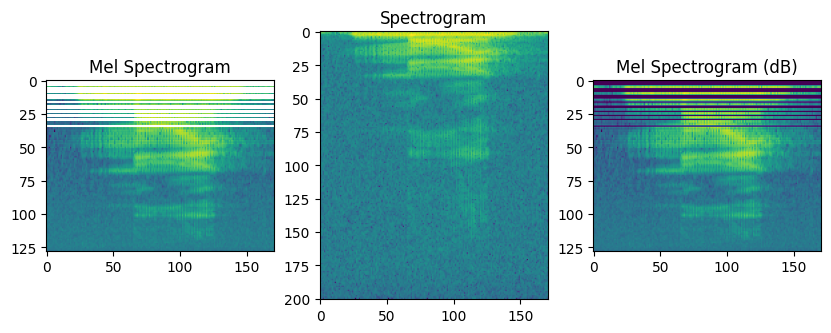

In [20]:
import torch
import matplotlib.pyplot as plt
from torchaudio.transforms import MelSpectrogram, Spectrogram, AmplitudeToDB

waveform, sample_rate = torchaudio.load(train_audio_files[0])

mel_spectrogram = MelSpectrogram(sample_rate=sample_rate)(waveform)
spectrogram = Spectrogram()(waveform)
amplitude_to_db = AmplitudeToDB()(mel_spectrogram)


plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Mel Spectrogram')
plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
plt.subplot(1, 3, 2)
plt.title('Spectrogram')
plt.imshow(spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
plt.subplot(1, 3, 3)
plt.title('Mel Spectrogram (dB)')
plt.imshow(amplitude_to_db[0,:,:].numpy(), cmap='viridis')
plt.show()

In [6]:
class AudioMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, audio_dir_path, audio_file_names, num_samples, labels, transforms):
        super().__init__()
        self.audio_dir_path = audio_dir_path
        self.audio_file_names = audio_file_names
        self.num_samples = num_samples
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        signal, sr = torchaudio.load(os.path.join(self.audio_dir_path, self.audio_file_names[index]))
        signal = self.mix_down_if_necessary(signal)
        signal = self.cut_if_necessary(signal)
        signal = self.right_pad_if_necessary(signal)
        signal = self.transforms(signal)
        label = (self.labels[index])
        return signal, label

    def __len__(self):
        return len(self.labels)

    def mix_down_if_necessary(self, signal): #converting from stereo to mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim = 0, keepdims = True)
        return signal

    def cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :num_samples]
        return signal

    def right_pad_if_necessary(self, signal):
        length = signal.shape[1]
        if self.num_samples > length:
            pad_last_dim = (0, num_samples - length)
            signal = torch.nn.functional.pad(signal, pad_last_dim)
        return signal

In [7]:
# наверно не совсем правильно, но как получилось
# я буду сравнивать 3 модели. 1ая будет обучатся на данных с трансформером MFCC,
# 2ая - MelSpectrogram, 3я - LFCC
num_samples = 16000

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [21]:
# MFCC
train_dataset = AudioMNISTDataset(train_data_path, train_file_names, num_samples, train_labels, torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=13))
test_dataset = AudioMNISTDataset(test_data_path, test_file_names, num_samples, test_labels, torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=13))

In [22]:
# Mel Spectrogram
train_dataset_1 = AudioMNISTDataset(train_data_path, train_file_names, num_samples, train_labels, MelSpectrogram())
test_dataset_1 = AudioMNISTDataset(test_data_path, test_file_names, num_samples, test_labels, MelSpectrogram())

In [23]:
# LFCC
train_dataset_2 = AudioMNISTDataset(train_data_path, train_file_names, num_samples, train_labels, torchaudio.transforms.LFCC())
test_dataset_2 = AudioMNISTDataset(test_data_path, test_file_names, num_samples, test_labels, torchaudio.transforms.LFCC())

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 128)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = False, batch_size = 128)

In [25]:
train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, shuffle = True, batch_size = 128)
test_loader_1 = torch.utils.data.DataLoader(test_dataset_1, shuffle = False, batch_size = 128)

In [26]:
train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, shuffle = True, batch_size = 128)
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, shuffle = False, batch_size = 128)

In [15]:
# MFCC
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 20, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 64 * 3 * 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# Mel Spectrogram
class SimpleCNN_2(nn.Module):
    def __init__(self):
        super(SimpleCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 20, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 64 * 32 * 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [27]:
# LFCC
class SimpleCNN_3(nn.Module):
    def __init__(self):
        super(SimpleCNN_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 10 * 20, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 64 * 10 * 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
import tqdm
from tqdm.auto import tqdm

def train_stochastic(model, loader, criterion, optimizer, num_epoch):
    for epoch in tqdm(range(num_epoch)):
        model.train()
        epoch_loss = []
        k = 0

        for X_batch, y_batch in loader:
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        print(f'Epoch {epoch+1}, Loss: {np.mean(epoch_loss)}')

    return model

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_stochastic(model, train_loader, criterion, optimizer, num_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
Epoch 1, Loss: 2.240624949844046
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3840, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
model2 = SimpleCNN_2()

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [23]:
#model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [26]:
train_stochastic(model2, train_loader_1, criterion, optimizer, num_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 1.1171181489798157
Epoch 2, Loss: 0.5379082379354672
Epoch 3, Loss: 0.35658630237660627
Epoch 4, Loss: 0.272829979065467
Epoch 5, Loss: 0.24514651052992453
Epoch 6, Loss: 0.18616132230751894
Epoch 7, Loss: 0.16000259470787237
Epoch 8, Loss: 0.13059429997916927
Epoch 9, Loss: 0.11012002679688687
Epoch 10, Loss: 0.11121327730573037


SimpleCNN_2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=40960, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [29]:
model3 = SimpleCNN_3()

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-3)

In [31]:
train_stochastic(model3, train_loader_2, criterion, optimizer, num_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 3.015013797208667
Epoch 2, Loss: 0.3282832873307846
Epoch 3, Loss: 0.25156128059395333
Epoch 4, Loss: 0.20965177002786237
Epoch 5, Loss: 0.17268495380201124
Epoch 6, Loss: 0.1459567595950582
Epoch 7, Loss: 0.10625667893327773
Epoch 8, Loss: 0.08629997248697857
Epoch 9, Loss: 0.07158234682653776
Epoch 10, Loss: 0.061652099578747184


SimpleCNN_3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# MFCC
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 94.93333333333334%


In [35]:
# Mel Spectrogram
model2.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader_1:
        outputs = model2(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 88.18666666666667%


In [32]:
# LFCC
model3.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader_2:
        outputs = model3(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 94.17333333333333%


В итоге самая точная модель - 1ая, где использовался трансформер MFCC